In [2]:
import pandas as pd
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa
import simpledorff  # per Krippendorff come prima

In [3]:
file_name = "annotated_multipico.xlsx"
sheet_names = ['Alessandro', 'Cristina', 'Eliana', 'Michele', 'Michael', 'Elisa']
df = pd.read_excel(file_name, sheet_name=sheet_names)
df['Alessandro'].head()

,level,source,reply,post,language,language_variety,reply_id,post_id,majority_vote,Unnamed: 9,rhetorical figure,comment
0,2,twitter,@USER @USER Anche per rompere il ghiaccio,@USER Gianca già che ci sei regalale un paio d...,it,it,15902900000000000000,7961696982295378944,1,NaN,"CONTEXT SHIFT, HYPERBOLE",NaN
1,2,twitter,@USER Nonnino! Già sveglio? ??,@USER Non troppo buongiorno,it,it,4652170000000000000,4824587311292975104,1,NaN,"RHETORICAL QUESTION, HYPERBOLE",NaN
2,1,twitter,@USER il terrone di essere rimpiazzata,il terrore di essere rimpiazzata,it,it,18161900000000000000,7155693771356047360,1,NaN,"CONTEXT SHIFT, OTHER",NaN
3,1,twitter,@USER Tanto per non essere banali,"Elly #Schlein: ""Il lavoro deve tornare a esser...",it,it,5855670000000000000,5929177359346716672,1,NaN,FALSE ASSERTION,NaN
4,1,reddit,Se le toghe rosse avessere mandato un avviso d...,Se solo la società perseguisse l'obiettivo di ...,it,it,10284800000000000000,12099038560420169728,1,NaN,"OXYMORON, ANALOGY",NaN


In [4]:
# DROP colonne indesiderate subito dopo il caricamento
cols_to_drop = ['level', 'source', 'language', 'language_variety', 'majority_vote', 'Unnamed: 9', 'comment']
for name in df:
    df[name] = df[name].drop(columns=[col for col in cols_to_drop if col in df[name].columns])
df['Alessandro'].head()

,reply,post,reply_id,post_id,rhetorical figure
0,@USER @USER Anche per rompere il ghiaccio,@USER Gianca già che ci sei regalale un paio d...,15902900000000000000,7961696982295378944,"CONTEXT SHIFT, HYPERBOLE"
1,@USER Nonnino! Già sveglio? ??,@USER Non troppo buongiorno,4652170000000000000,4824587311292975104,"RHETORICAL QUESTION, HYPERBOLE"
2,@USER il terrone di essere rimpiazzata,il terrore di essere rimpiazzata,18161900000000000000,7155693771356047360,"CONTEXT SHIFT, OTHER"
3,@USER Tanto per non essere banali,"Elly #Schlein: ""Il lavoro deve tornare a esser...",5855670000000000000,5929177359346716672,FALSE ASSERTION
4,Se le toghe rosse avessere mandato un avviso d...,Se solo la società perseguisse l'obiettivo di ...,10284800000000000000,12099038560420169728,"OXYMORON, ANALOGY"


In [5]:
# Per ogni foglio, tieni solo righe con 'rhetorical figure' non-NaN
cleaned = {
    name: sheet[sheet['rhetorical figure'].notna()][['post_id', 'reply_id']]
    for name, sheet in df.items()
}

sets_of_pairs = [set(zip(sheet['post_id'], sheet['reply_id'])) for sheet in cleaned.values()]
common_pairs = set.intersection(*sets_of_pairs)
print(f"Coppie (post_id, reply_id) comuni con 'rhetorical figure' non-NaN in tutti i fogli: {len(common_pairs)}")

final_cleaned = {}
for name, sheet in df.items():
    mask = sheet.apply(lambda row: (row['post_id'], row['reply_id']) in common_pairs, axis=1)
    mask &= sheet['rhetorical figure'].notna()
    final_cleaned[name] = sheet[mask].copy()

for sheet_name in sheet_names:
    print(f"Numero di post in {sheet_name}: {len(final_cleaned[sheet_name])}")

final_cleaned['Alessandro'].head()

Coppie (post_id, reply_id) comuni con 'rhetorical figure' non-NaN in tutti i fogli: 55
Numero di post in Alessandro: 55
Numero di post in Cristina: 55
Numero di post in Eliana: 55
Numero di post in Michele: 55
Numero di post in Michael: 55
Numero di post in Elisa: 55


,reply,post,reply_id,post_id,rhetorical figure
0,@USER @USER Anche per rompere il ghiaccio,@USER Gianca già che ci sei regalale un paio d...,15902900000000000000,7961696982295378944,"CONTEXT SHIFT, HYPERBOLE"
1,@USER Nonnino! Già sveglio? ??,@USER Non troppo buongiorno,4652170000000000000,4824587311292975104,"RHETORICAL QUESTION, HYPERBOLE"
2,@USER il terrone di essere rimpiazzata,il terrore di essere rimpiazzata,18161900000000000000,7155693771356047360,"CONTEXT SHIFT, OTHER"
3,@USER Tanto per non essere banali,"Elly #Schlein: ""Il lavoro deve tornare a esser...",5855670000000000000,5929177359346716672,FALSE ASSERTION
4,Se le toghe rosse avessere mandato un avviso d...,Se solo la società perseguisse l'obiettivo di ...,10284800000000000000,12099038560420169728,"OXYMORON, ANALOGY"


In [6]:
# Estrai tutte le figure retoriche da tutti i fogli, normalizzate
all_figures_set = set()

def normalize_figures(cell):
    # Gestione NaN
    if pd.isna(cell):
        return []
    figures = [f.strip().upper() for f in str(cell).split(',')]
    # Sostituzione specifica
    figures = ["OXYMORON" if f == "OXYMORON/PARADOX" else f for f in figures]
    figures = ["EUPHEMISM" if f == "EUPHEMINSM" else f for f in figures]
    return figures

# Raccogli tutte le figure da tutti i fogli
for sheet in final_cleaned.values():
    for entry in sheet['rhetorical figure'].dropna():
        all_figures_set.update(normalize_figures(entry))

# Ordina per consistenza
all_figures = sorted(all_figures_set)

# Aggiungi una colonna per ciascuna figura: 1 se presente, 0 altrimenti
for name, sheet in final_cleaned.items():
    for fig in all_figures:
        sheet[fig] = sheet['rhetorical figure'].apply(
            lambda x: 1 if fig in normalize_figures(x) else 0
        )
    final_cleaned[name] = sheet  # Aggiorna

final_cleaned['Alessandro'].head()

,reply,post,reply_id,post_id,rhetorical figure,ANALOGY,CONTEXT SHIFT,EUPHEMISM,FALSE ASSERTION,HYPERBOLE,OTHER,OXYMORON,RHETORICAL QUESTION
0,@USER @USER Anche per rompere il ghiaccio,@USER Gianca già che ci sei regalale un paio d...,15902900000000000000,7961696982295378944,"CONTEXT SHIFT, HYPERBOLE",0,1,0,0,1,0,0,0
1,@USER Nonnino! Già sveglio? ??,@USER Non troppo buongiorno,4652170000000000000,4824587311292975104,"RHETORICAL QUESTION, HYPERBOLE",0,0,0,0,1,0,0,1
2,@USER il terrone di essere rimpiazzata,il terrore di essere rimpiazzata,18161900000000000000,7155693771356047360,"CONTEXT SHIFT, OTHER",0,1,0,0,0,1,0,0
3,@USER Tanto per non essere banali,"Elly #Schlein: ""Il lavoro deve tornare a esser...",5855670000000000000,5929177359346716672,FALSE ASSERTION,0,0,0,1,0,0,0,0
4,Se le toghe rosse avessere mandato un avviso d...,Se solo la società perseguisse l'obiettivo di ...,10284800000000000000,12099038560420169728,"OXYMORON, ANALOGY",1,0,0,0,0,0,1,0


In [7]:
def safe_krippendorff(df, class_col):
    unique_values = df[class_col].dropna().unique()
    if len(unique_values) <= 1:
        print(f"Non abbastanza variazione nei dati per calcolare Krippendorff's alpha per {class_col}")
        return None
    try:
        return simpledorff.calculate_krippendorffs_alpha_for_df(
            df,
            experiment_col='unit_id',
            annotator_col='annotator_id',
            class_col=class_col
        )
    except ZeroDivisionError:
        print(f"Divisione per zero durante il calcolo di Krippendorff's alpha per {class_col}")
        return None

def calc_alpha_for_group(final_cleaned, annotators, figures):
    print(f"\nCalcolo Krippendorff's alpha per annotatori: {annotators}")
    results = {}
    for fig in figures:
        rows = []
        for annotator in annotators:
            df_annot = final_cleaned[annotator]
            for _, row in df_annot.iterrows():
                unit_id = (row['post_id'], row['reply_id'])
                value = row[fig]
                rows.append([unit_id, annotator, value])
        df_for_alpha = pd.DataFrame(rows, columns=['unit_id', 'annotator_id', 'Annotation'])
        alpha = safe_krippendorff(df_for_alpha, 'Annotation')
        if alpha is not None:
            results[fig] = alpha
            print(f"  Figura '{fig}': alpha = {alpha:.3f}")
    if results:
        avg_alpha = sum(results.values()) / len(results)
        print(f"  Alpha medio: {avg_alpha:.3f}")
    else:
        print("  Nessun alpha calcolato correttamente.")
    return results

def calc_fleiss_for_group(final_cleaned, annotators, figures):
    print(f"\nCalcolo Fleiss' kappa per annotatori: {annotators}")
    results = {}
    for fig in figures:
        # Prepara matrice righe=unità, colonne=categorie (qui 0 o 1)
        # Costruiamo matrice (unità x categorie) con conteggi annotatori
        # Per ogni unità (post_id, reply_id) contiamo quanti annotatori hanno messo 1 e quanti 0
        
        # Primo, unisci le annotazioni di tutti gli annotatori nel gruppo
        units = set()
        data_by_annotator = {}
        for annotator in annotators:
            df_annot = final_cleaned[annotator][['post_id', 'reply_id', fig]].copy()
            df_annot['unit_id'] = list(zip(df_annot['post_id'], df_annot['reply_id']))
            data_by_annotator[annotator] = df_annot.set_index('unit_id')[fig]
            units.update(df_annot['unit_id'])
        
        units = sorted(units)
        # Costruisci la matrice di conteggi: righe=unità, colonne=[num_0, num_1]
        matrix = []
        for unit in units:
            counts = [0,0]  # [num_0, num_1]
            for annotator in annotators:
                val = data_by_annotator[annotator].get(unit, np.nan)
                if pd.isna(val):
                    # Se manca annotazione, saltiamo (non contiamo)
                    continue
                elif val == 1:
                    counts[1] += 1
                else:
                    counts[0] += 1
            # Solo includi unità con almeno un voto valido
            if sum(counts) > 0:
                matrix.append(counts)
        
        matrix = np.array(matrix)
        
        if matrix.shape[0] == 0:
            print(f"  Figura '{fig}': nessun dato valido per Fleiss' kappa")
            continue
        try:
            kappa = fleiss_kappa(matrix)
            results[fig] = kappa
            print(f"  Figura '{fig}': Fleiss' kappa = {kappa:.3f}")
        except Exception as e:
            print(f"  Figura '{fig}': errore calcolo Fleiss' kappa: {e}")
    if results:
        avg_kappa = sum(results.values()) / len(results)
        print(f"  Kappa medio: {avg_kappa:.3f}")
    else:
        print("  Nessun kappa calcolato correttamente.")
    return results

# --- Usa le funzioni ---
all_annotators = list(final_cleaned.keys())
figures = all_figures

# 1) Tutti gli annotatori insieme
print("\nCalcolo agreement tra tutti gli annotatori:")
alpha_all = calc_alpha_for_group(final_cleaned, all_annotators, figures)
kappa_all = calc_fleiss_for_group(final_cleaned, all_annotators, figures)

# 2) Coppie specifiche
print("\nCalcolo agreement tra gruppi sudivisi per generazione:")
pairs = [
    ('Alessandro', 'Cristina'),
    ('Eliana', 'Michele'),
    ('Michael', 'Elisa')
]
for pair in pairs:
    calc_alpha_for_group(final_cleaned, list(pair), figures)
    calc_fleiss_for_group(final_cleaned, list(pair), figures)

# 3) Gruppi di 3
print("\nCalcolo agreement tra gruppi suddivisi per genere:")
triplets = [
    ('Alessandro', 'Michele', 'Michael'),
    ('Cristina', 'Eliana', 'Elisa')
]
for group in triplets:
    calc_alpha_for_group(final_cleaned, list(group), figures)
    calc_fleiss_for_group(final_cleaned, list(group), figures)


Calcolo agreement tra tutti gli annotatori:

Calcolo Krippendorff's alpha per annotatori: ['Alessandro', 'Cristina', 'Eliana', 'Michele', 'Michael', 'Elisa']
  Figura 'ANALOGY': alpha = 0.141
  Figura 'CONTEXT SHIFT': alpha = 0.116
  Figura 'EUPHEMISM': alpha = 0.056
  Figura 'FALSE ASSERTION': alpha = 0.139
  Figura 'HYPERBOLE': alpha = 0.357
  Figura 'OTHER': alpha = 0.147
  Figura 'OXYMORON': alpha = 0.042
  Figura 'RHETORICAL QUESTION': alpha = 0.513
  Alpha medio: 0.189

Calcolo Fleiss' kappa per annotatori: ['Alessandro', 'Cristina', 'Eliana', 'Michele', 'Michael', 'Elisa']
  Figura 'ANALOGY': Fleiss' kappa = 0.138
  Figura 'CONTEXT SHIFT': Fleiss' kappa = 0.114
  Figura 'EUPHEMISM': Fleiss' kappa = 0.053
  Figura 'FALSE ASSERTION': Fleiss' kappa = 0.136
  Figura 'HYPERBOLE': Fleiss' kappa = 0.355
  Figura 'OTHER': Fleiss' kappa = 0.144
  Figura 'OXYMORON': Fleiss' kappa = 0.039
  Figura 'RHETORICAL QUESTION': Fleiss' kappa = 0.512
  Kappa medio: 0.186

Calcolo agreement tra gru

In [8]:
def count_figures_per_annotator(final_cleaned, annotators, figures):
    print("\nConteggio figure retoriche per annotatore:")
    counts = {}
    for annotator in annotators:
        counts[annotator] = {}
        df = final_cleaned[annotator]
        for fig in figures:
            counts[annotator][fig] = df[fig].sum()
        print(f"Annotatore {annotator}:")
        for fig, count in counts[annotator].items():
            print(f"  {fig}: {count}")
    return counts

# Usa la funzione
counts = count_figures_per_annotator(final_cleaned, all_annotators, figures)



Conteggio figure retoriche per annotatore:
Annotatore Alessandro:
  ANALOGY: 19
  CONTEXT SHIFT: 19
  EUPHEMISM: 13
  FALSE ASSERTION: 12
  HYPERBOLE: 15
  OTHER: 12
  OXYMORON: 2
  RHETORICAL QUESTION: 14
Annotatore Cristina:
  ANALOGY: 1
  CONTEXT SHIFT: 25
  EUPHEMISM: 10
  FALSE ASSERTION: 2
  HYPERBOLE: 7
  OTHER: 8
  OXYMORON: 10
  RHETORICAL QUESTION: 7
Annotatore Eliana:
  ANALOGY: 7
  CONTEXT SHIFT: 13
  EUPHEMISM: 2
  FALSE ASSERTION: 6
  HYPERBOLE: 5
  OTHER: 15
  OXYMORON: 2
  RHETORICAL QUESTION: 16
Annotatore Michele:
  ANALOGY: 1
  CONTEXT SHIFT: 10
  EUPHEMISM: 0
  FALSE ASSERTION: 8
  HYPERBOLE: 8
  OTHER: 20
  OXYMORON: 14
  RHETORICAL QUESTION: 8
Annotatore Michael:
  ANALOGY: 5
  CONTEXT SHIFT: 8
  EUPHEMISM: 6
  FALSE ASSERTION: 14
  HYPERBOLE: 12
  OTHER: 11
  OXYMORON: 1
  RHETORICAL QUESTION: 14
Annotatore Elisa:
  ANALOGY: 9
  CONTEXT SHIFT: 13
  EUPHEMISM: 0
  FALSE ASSERTION: 18
  HYPERBOLE: 9
  OTHER: 4
  OXYMORON: 2
  RHETORICAL QUESTION: 5


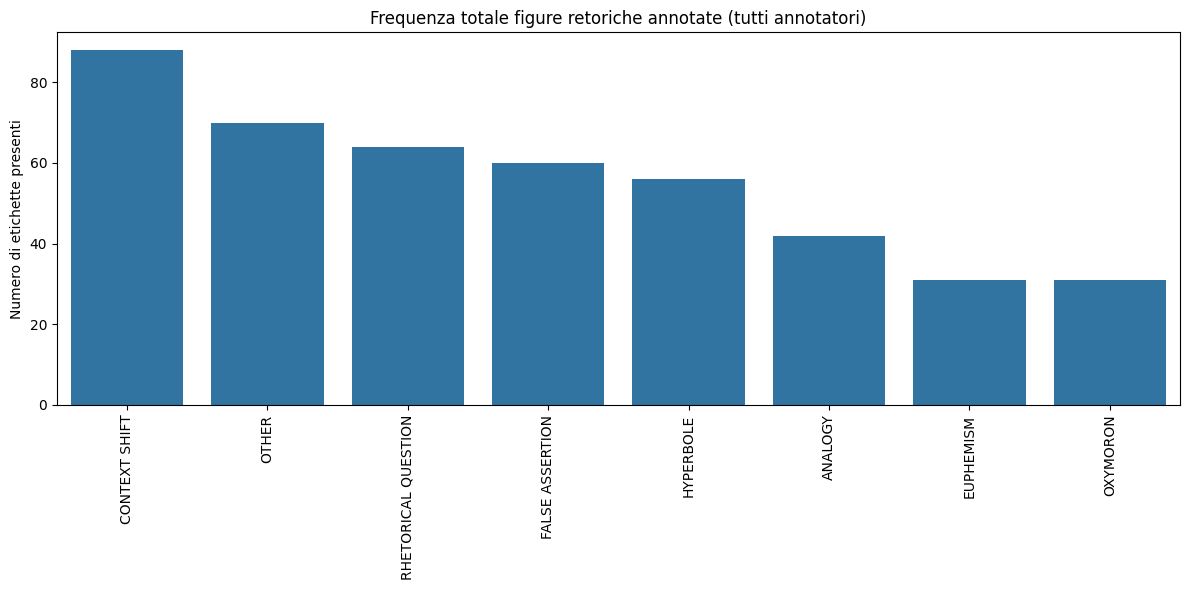

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2a) Distribuzione totale figure retoriche (somma su tutti annotatori)
total_counts = {fig: 0 for fig in figures}
for annotator in all_annotators:
    df = final_cleaned[annotator]
    for fig in figures:
        total_counts[fig] += df[fig].sum()

# Ordina per frequenza decrescente
sorted_counts = dict(sorted(total_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12,6))
sns.barplot(x=list(sorted_counts.keys()), y=list(sorted_counts.values()))
plt.xticks(rotation=90)
plt.title("Frequenza totale figure retoriche annotate (tutti annotatori)")
plt.ylabel("Numero di etichette presenti")
plt.tight_layout()
plt.show()


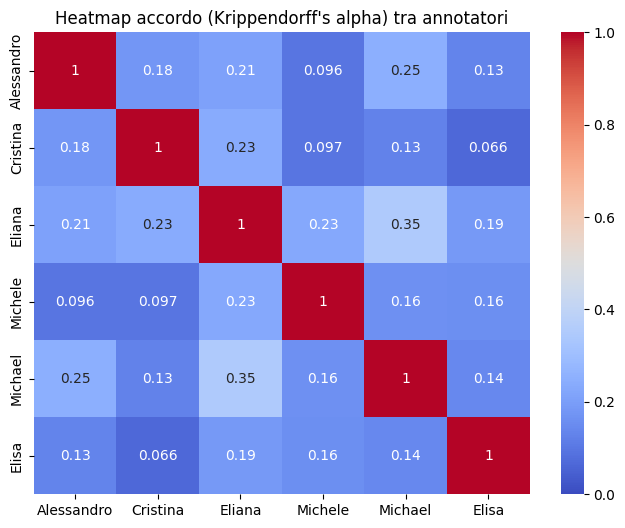

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import simpledorff  # Assumi che sia installato e importabile

def calc_kripp_for_pair(df1, df2, figures):
    alphas = []
    # Trova unità comuni (post_id, reply_id)
    units1 = set(zip(df1['post_id'], df1['reply_id']))
    units2 = set(zip(df2['post_id'], df2['reply_id']))
    common_units = units1.intersection(units2)
    if len(common_units) == 0:
        return np.nan

    for fig in figures:
        rows = []
        for unit in common_units:
            val1 = df1[(df1['post_id'] == unit[0]) & (df1['reply_id'] == unit[1])][fig].values
            val2 = df2[(df2['post_id'] == unit[0]) & (df2['reply_id'] == unit[1])][fig].values
            if len(val1) == 0 or len(val2) == 0:
                continue
            rows.append([unit, 'annotator1', val1[0]])
            rows.append([unit, 'annotator2', val2[0]])

        if len(rows) == 0:
            continue

        df_for_alpha = pd.DataFrame(rows, columns=['unit_id', 'annotator_id', 'Annotation'])

        unique_values = df_for_alpha['Annotation'].dropna().unique()
        if len(unique_values) <= 1:
            continue

        try:
            alpha = simpledorff.calculate_krippendorffs_alpha_for_df(
                df_for_alpha,
                experiment_col='unit_id',
                annotator_col='annotator_id',
                class_col='Annotation'
            )
            alphas.append(alpha)
        except ZeroDivisionError:
            continue

    if alphas:
        return np.mean(alphas)
    else:
        return np.nan

annotators = list(final_cleaned.keys())
figures = all_figures

# Inizializza matrice vuota
alpha_matrix = pd.DataFrame(index=annotators, columns=annotators, dtype=float)

for i, ann1 in enumerate(annotators):
    for j, ann2 in enumerate(annotators):
        if i == j:
            alpha_matrix.loc[ann1, ann2] = 1.0  # accordo perfetto
        elif pd.isna(alpha_matrix.loc[ann1, ann2]):
            df1 = final_cleaned[ann1]
            df2 = final_cleaned[ann2]

            alpha = calc_kripp_for_pair(df1, df2, figures)

            alpha_matrix.loc[ann1, ann2] = alpha
            alpha_matrix.loc[ann2, ann1] = alpha  # simmetrico

plt.figure(figsize=(8,6))
sns.heatmap(alpha_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Heatmap accordo (Krippendorff's alpha) tra annotatori")
plt.show()


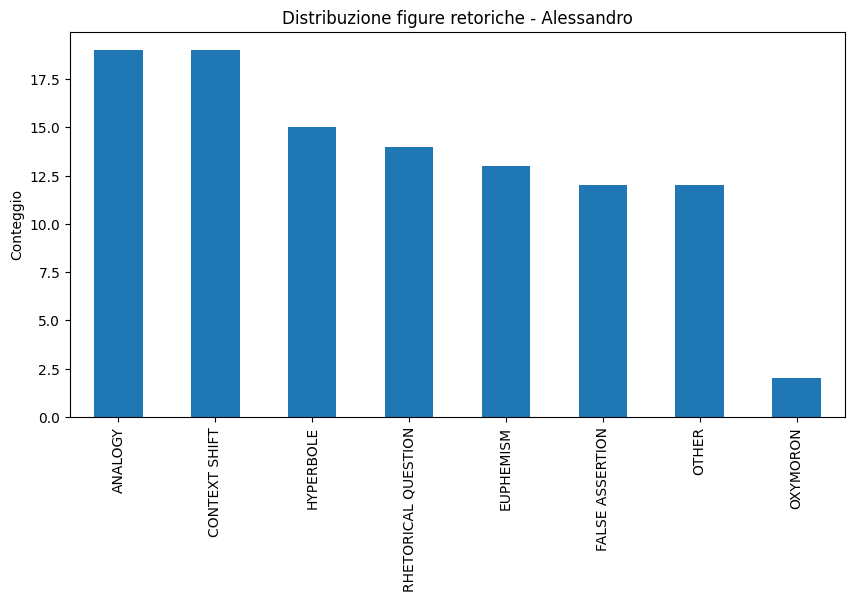

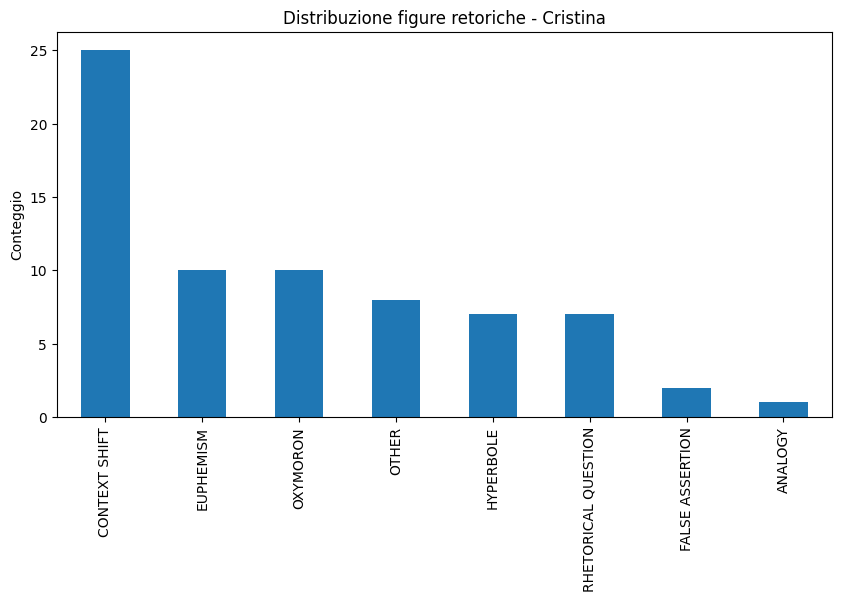

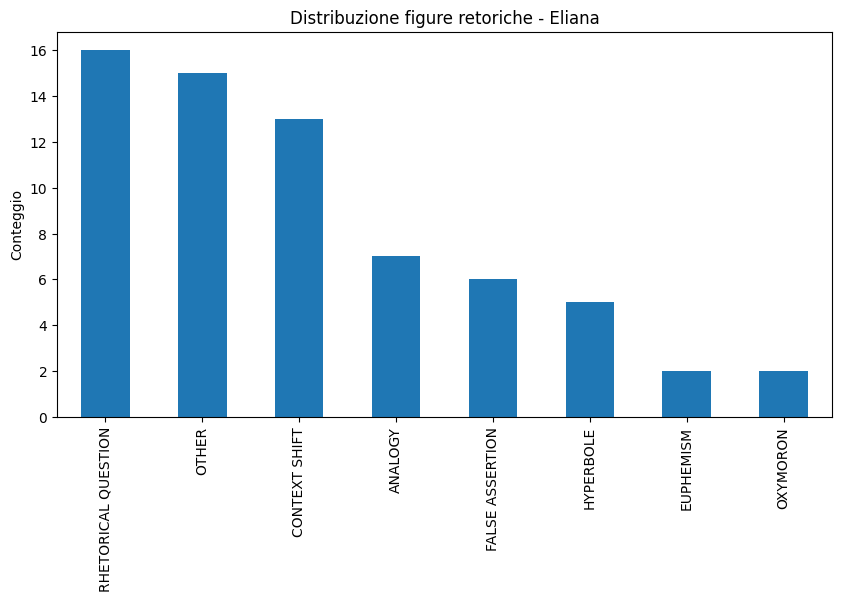

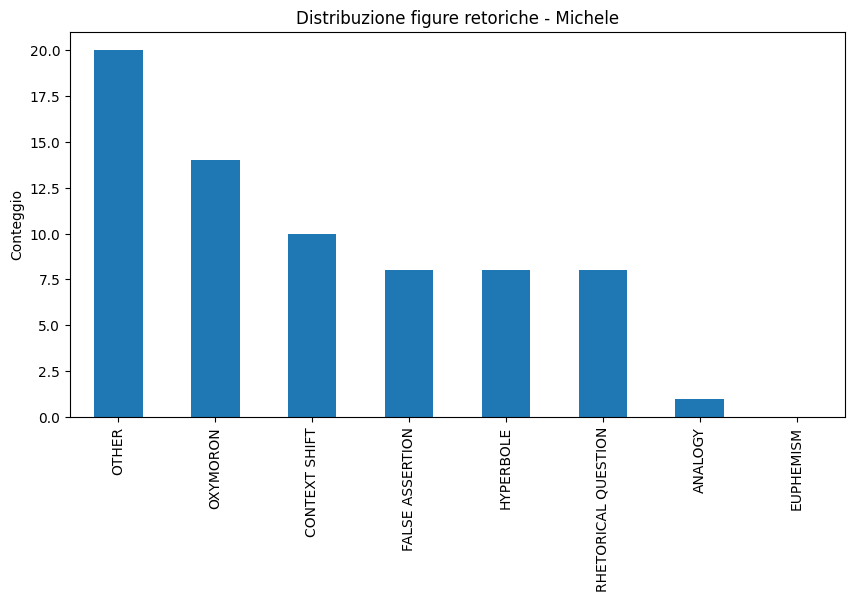

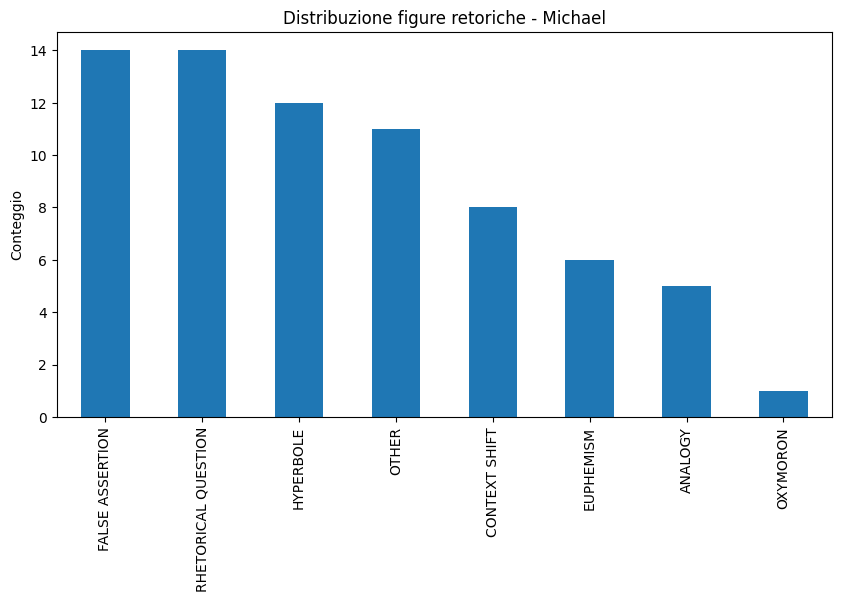

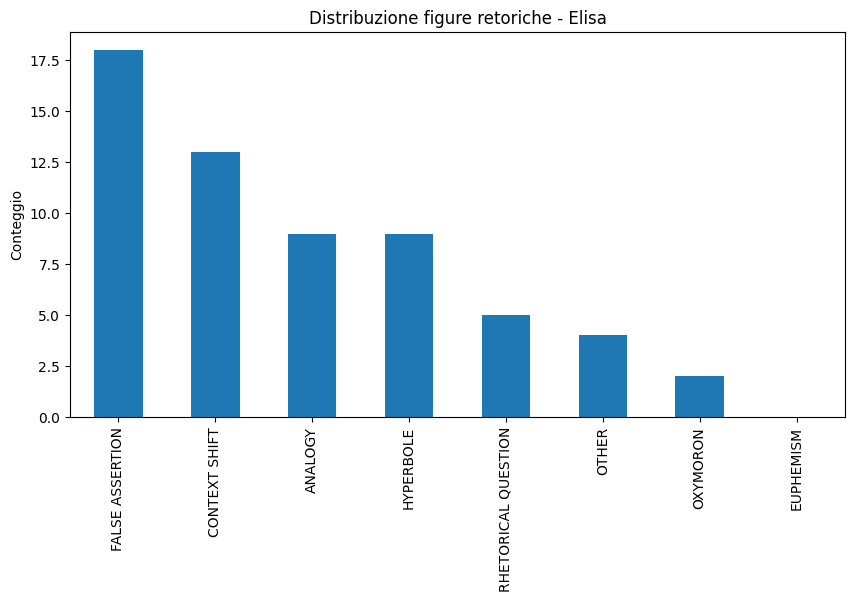

In [11]:
import matplotlib.pyplot as plt

for annotator in annotators:
    counts = final_cleaned[annotator][all_figures].sum().sort_values(ascending=False)
    plt.figure(figsize=(10,5))
    counts.plot(kind='bar')
    plt.title(f"Distribuzione figure retoriche - {annotator}")
    plt.ylabel("Conteggio")
    plt.show()


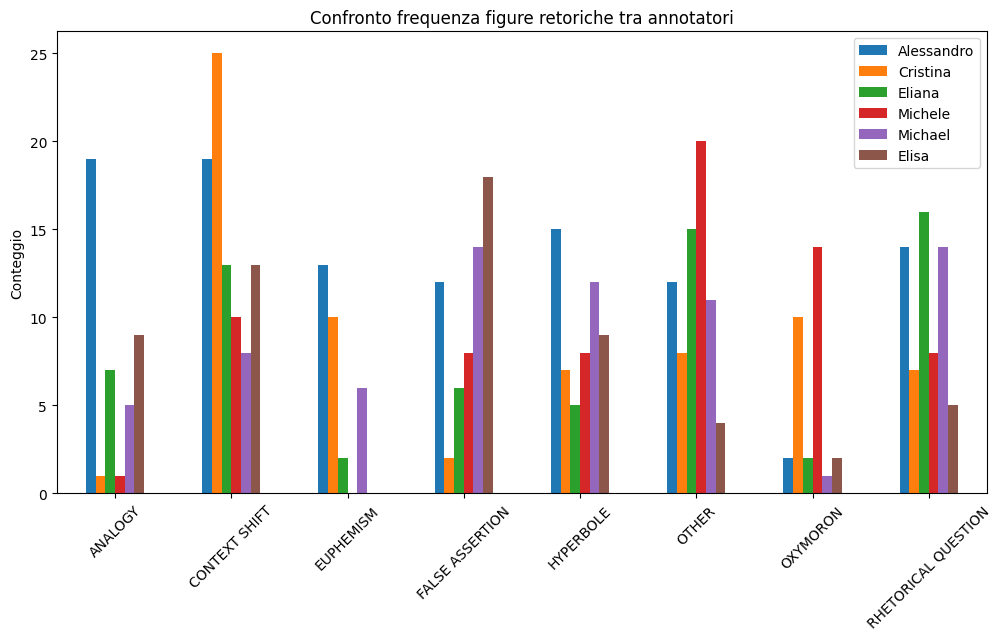

In [12]:
counts_df = pd.DataFrame({ann: final_cleaned[ann][all_figures].sum() for ann in annotators})
counts_df.plot(kind='bar', figsize=(12,6))
plt.title("Confronto frequenza figure retoriche tra annotatori")
plt.ylabel("Conteggio")
plt.xticks(rotation=45)
plt.show()



Calcolo Krippendorff's alpha per annotatori: ['Alessandro', 'Cristina']
  Figura 'ANALOGY': alpha = -0.090
  Figura 'CONTEXT SHIFT': alpha = 0.324
  Figura 'EUPHEMISM': alpha = 0.074
  Figura 'FALSE ASSERTION': alpha = 0.189
  Figura 'HYPERBOLE': alpha = 0.212
  Figura 'OTHER': alpha = 0.152
  Figura 'OXYMORON': alpha = 0.073
  Figura 'RHETORICAL QUESTION': alpha = 0.475
  Alpha medio: 0.176

Calcolo Krippendorff's alpha per annotatori: ['Alessandro', 'Eliana']
  Figura 'ANALOGY': alpha = 0.102
  Figura 'CONTEXT SHIFT': alpha = 0.039
  Figura 'EUPHEMISM': alpha = 0.006
  Figura 'FALSE ASSERTION': alpha = 0.210
  Figura 'HYPERBOLE': alpha = 0.152
  Figura 'OTHER': alpha = 0.368
  Figura 'OXYMORON': alpha = -0.028
  Figura 'RHETORICAL QUESTION': alpha = 0.818
  Alpha medio: 0.208

Calcolo Krippendorff's alpha per annotatori: ['Alessandro', 'Michele']
  Figura 'ANALOGY': alpha = -0.090
  Figura 'CONTEXT SHIFT': alpha = 0.026
  Figura 'EUPHEMISM': alpha = -0.124
  Figura 'FALSE ASSERTION'

C:\Users\micha\AppData\Local\Temp\ipykernel_2904\2487455788.py:24: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dist_matrix, 'ward')


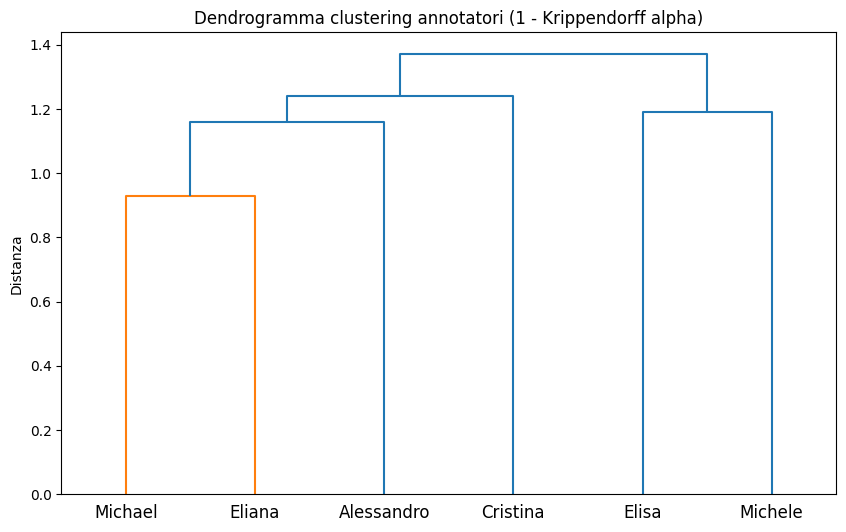

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np

# Dendrogramma di clustering degli annotatori basato su 1 - Krippendorff alpha
# Funzione per calcolare matrice distanza 1 - Krippendorff alpha tra annotatori
def krippendorff_distance_matrix(final_cleaned, annotators, figures):
    n = len(annotators)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            alpha_res = calc_alpha_for_group(final_cleaned, [annotators[i], annotators[j]], figures)
            # media alpha su tutte le figure, se non calcolabile metti 0 (nessun accordo)
            alpha_mean = np.mean(list(alpha_res.values())) if alpha_res else 0
            dist = 1 - alpha_mean
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

# Calcolo matrice distanza
dist_matrix = krippendorff_distance_matrix(final_cleaned, all_annotators, all_figures)

# Clustering gerarchico
linked = linkage(dist_matrix, 'ward')

# Dendrogramma
plt.figure(figsize=(10, 6))
dendrogram(linked,
           labels=all_annotators,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title("Dendrogramma clustering annotatori (1 - Krippendorff alpha)")
plt.ylabel("Distanza")
plt.show()


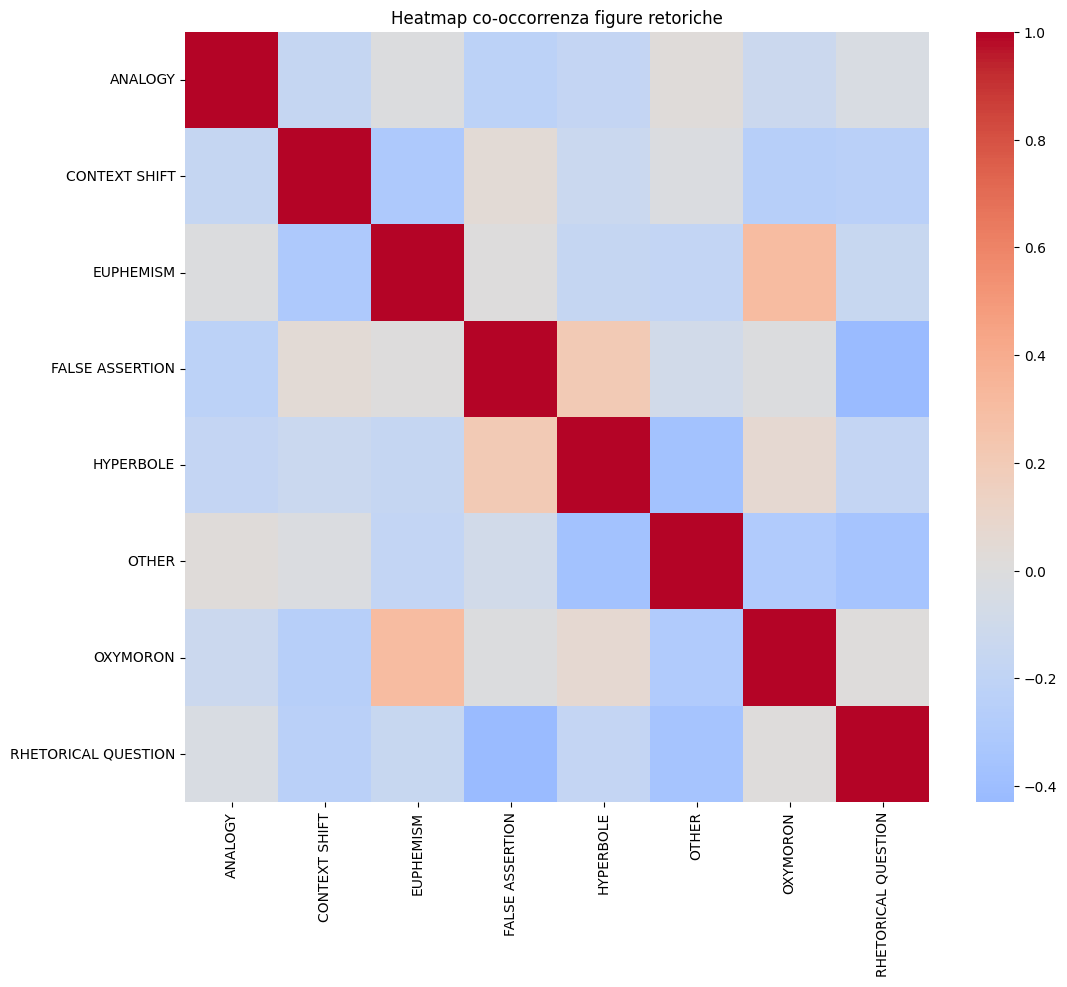

In [14]:
# 8. Heatmap delle co-occorrenze delle figure retoriche

import seaborn as sns

# Unisci i dati di tutti gli annotatori (su unità comuni) sommando le figure per unità
# Useremo final_cleaned ma solo sulle unità comuni già calcolate

# Costruisci dataframe con righe=unità, colonne=figure, valori=numero annotatori che hanno segnato la figura
units = sorted(list(common_pairs))
co_occurrence_matrix = pd.DataFrame(0, index=units, columns=all_figures)

for annotator in all_annotators:
    df = final_cleaned[annotator]
    df = df.set_index(['post_id', 'reply_id'])
    for unit in units:
        if unit in df.index:
            for fig in all_figures:
                co_occurrence_matrix.at[unit, fig] += df.at[unit, fig]

# Ora calcoliamo la co-occorrenza normalizzata tra le figure
# Calcoliamo la matrice di correlazione fra colonne (figure)
co_occ_corr = co_occurrence_matrix.corr()

plt.figure(figsize=(12,10))
sns.heatmap(co_occ_corr, cmap='coolwarm', center=0, annot=False)
plt.title("Heatmap co-occorrenza figure retoriche")
plt.show()


## Polarization index

In [20]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

def chi2_statistic(votes):
    """
    Calcola la statistica chi-quadro sui voti binari 0/1.
    votes: lista o array di 0/1
    """
    count_1 = sum(votes)
    count_0 = len(votes) - count_1
    # Distribuzione osservata
    observed = np.array([count_0, count_1])
    # Distribuzione attesa uniforme (se non ci sono preferenze, metà e metà)
    expected = np.full(2, len(votes) / 2)
    
    # Calcola la statistica chi-quadro manualmente (per evitare problemi con scipy su casi piccoli)
    with np.errstate(divide='ignore', invalid='ignore'):
        chi_sq = np.sum((observed - expected) ** 2 / expected)
    return chi_sq

def internal_agreement(votes):
    """
    Calcola a(G) = 1 - (chi2(G)/n) come accordo interno.
    votes: lista voti (0/1) per un gruppo di annotatori
    """
    n = len(votes)
    if n == 0:
        return 0
    chi_sq = chi2_statistic(votes)
    a_g = 1 - (chi_sq / n)
    # Normalizziamo in [0,1]
    return max(0, min(1, a_g))

def polarization_index(final_cleaned, groups, figure, common_pairs):
    """
    final_cleaned: dict con DataFrame per annotatore
    groups: lista di liste di annotatori (gruppi)
    figure: nome figura retorica (es "IRONY")
    common_pairs: set di (post_id, reply_id) comuni
    
    Ritorna P-index medio su tutte le istanze.
    """
    k = len(groups)
    polarization_scores = []
    
    for unit in common_pairs:
        # Voti per tutti gli annotatori
        votes_all = []
        for group in groups:
            # Voti del gruppo corrente
            votes_group = []
            for ann in group:
                df = final_cleaned[ann].set_index(['post_id', 'reply_id'])
                if unit in df.index:
                    votes_group.append(df.at[unit, figure])
            # Calcola accordo interno gruppo
            a_gw = internal_agreement(votes_group)
            
            # Memorizziamo per formula P(i)
            # Qui salviamo a(Gw), poi calcoliamo a(G) esternamente
            if 'a_gw_list' not in locals():
                a_gw_list = []
            a_gw_list.append(a_gw)
            
            votes_all.extend(votes_group)
        
        if votes_all:
            a_g = internal_agreement(votes_all)  # accordo totale
            # P(i)
            P_i = np.mean(a_gw_list) * (1 - a_g)
            polarization_scores.append(P_i)
        a_gw_list = []  # reset per prossima unità
    
    return np.mean(polarization_scores) if polarization_scores else None

# --- Esempio di uso ---

# Supponiamo di dividere gli annotatori in due gruppi (ad esempio per genere)
group1 = ['Alessandro', 'Michele', 'Michael']  # maschi
group2 = ['Cristina', 'Eliana', 'Elisa']     # femmine

groups = [group1, group2]

# common_pairs già definito come intersezione di tutte le unità annotate

# Per esempio calcoliamo il polarization index per la figura "IRONY"
fig = "EUPHEMISM"  # cambia con la figura retorica che vuoi analizzare

pi = polarization_index(final_cleaned, groups, fig, common_pairs)
print(f"Polarization Index per {fig}: {pi:.3f}")


Polarization Index per EUPHEMISM: 0.077


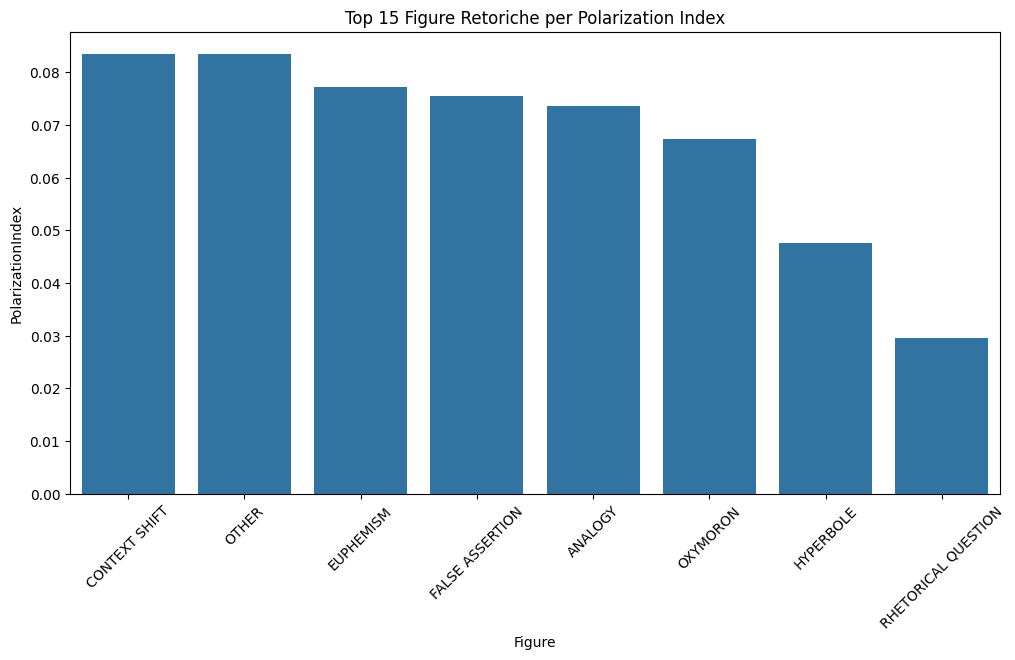

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola per tutte le figure
results = []
for fig in all_figures:
    pi = polarization_index(final_cleaned, groups, fig, common_pairs)
    if pi is not None:
        results.append({'Figure': fig, 'PolarizationIndex': pi})

df_pi = pd.DataFrame(results).sort_values('PolarizationIndex', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=df_pi.head(15), x='Figure', y='PolarizationIndex')
plt.xticks(rotation=45)
plt.title("Top 15 Figure Retoriche per Polarization Index")
plt.show()
